In [ ]:
%matplotlib inline

# Compute co-occurrence probability

This example shows how to compute the co-occurrence probability.

The co-occurrence score is defined as:

$$\frac{p(exp|cond)}{p(exp)}$$

where $p(exp|cond)$ is the conditional probability of observing a
cluster $exp$ conditioned on the presence of a cluster $cond$, whereas
$p(exp)$ is the probability of observing $exp$ in the radius size of
interest. The score is computed across increasing radii size around each
cell in the tissue.

::: seealso
See `sphx_glr_auto_examples_graph_compute_ripley.py` for another score
to describe spatial patterns with `squidpy.gr.ripley`.
:::


In [1]:
import squidpy as sq

adata = sq.datasets.imc()
adata

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.50M/1.50M [00:05<00:00, 307kB/s]


AnnData object with n_obs × n_vars = 4668 × 34
    obs: 'cell type'
    uns: 'cell type_colors'
    obsm: 'spatial'

We can compute the co-occurrence score with `squidpy.gr.co_occurrence`.
Results can be visualized with `squidpy.pl.co_occurrence`.


/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.71s/]


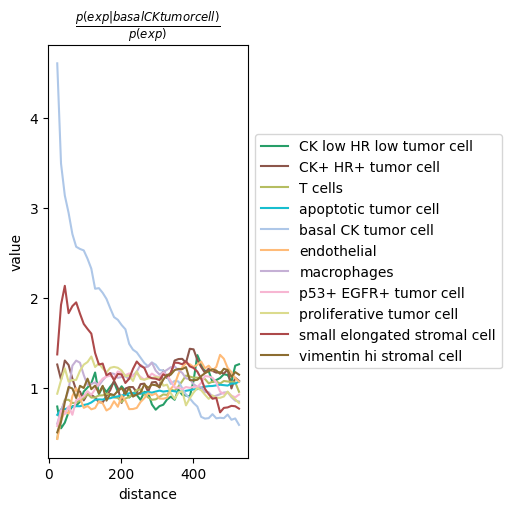

In [2]:
sq.gr.co_occurrence(adata, cluster_key="cell type")
sq.pl.co_occurrence(adata, cluster_key="cell type", clusters="basal CK tumor cell")

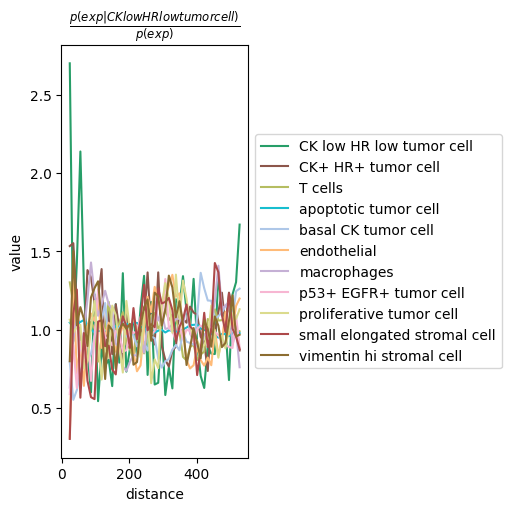

In [50]:
sq.pl.co_occurrence(adata, cluster_key="cell type", clusters="CK low HR low tumor cell")

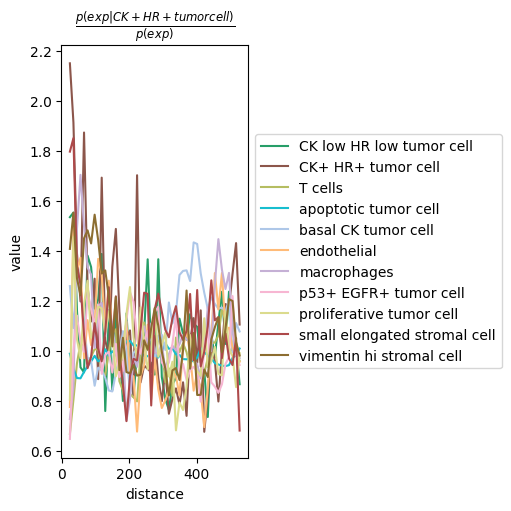

In [51]:
sq.pl.co_occurrence(adata, cluster_key="cell type", clusters="CK+ HR+ tumor cell")

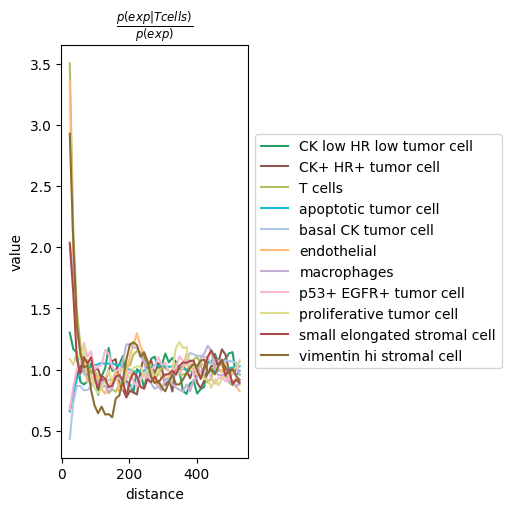

In [52]:
sq.pl.co_occurrence(adata, cluster_key="cell type", clusters="T cells")

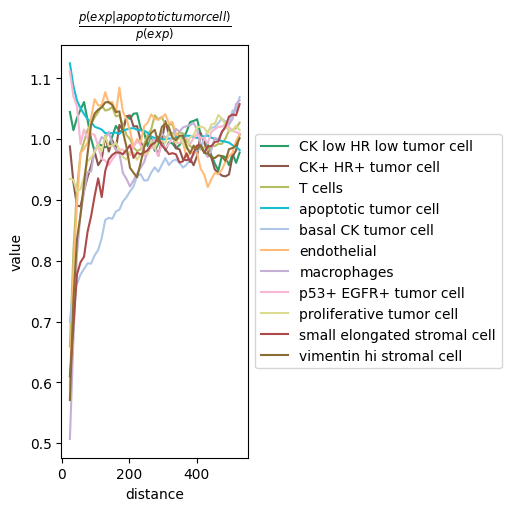

In [53]:
sq.pl.co_occurrence(adata, cluster_key="cell type", clusters="apoptotic tumor cell")

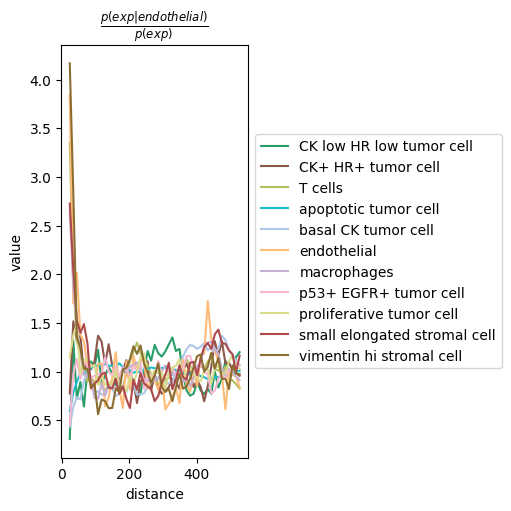

In [54]:
sq.pl.co_occurrence(adata, cluster_key="cell type", clusters="endothelial")

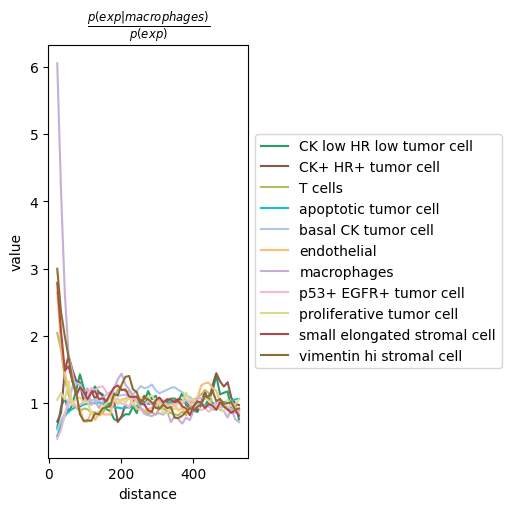

In [55]:
sq.pl.co_occurrence(adata, cluster_key="cell type", clusters="macrophages")

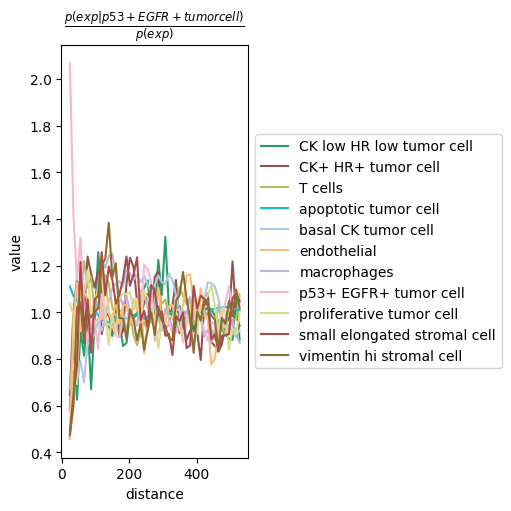

In [56]:
sq.pl.co_occurrence(adata, cluster_key="cell type", clusters="p53+ EGFR+ tumor cell")

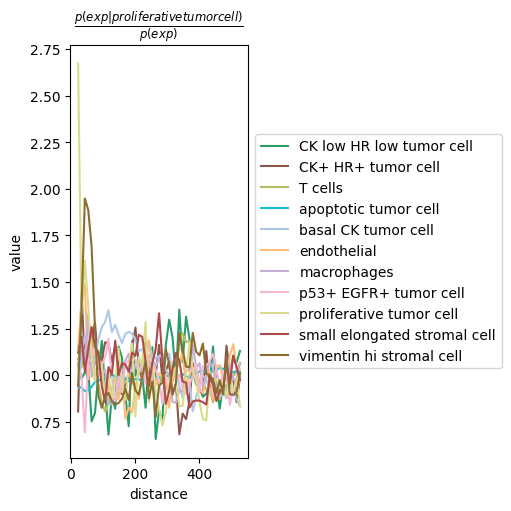

In [57]:
sq.pl.co_occurrence(adata, cluster_key="cell type", clusters="proliferative tumor cell")

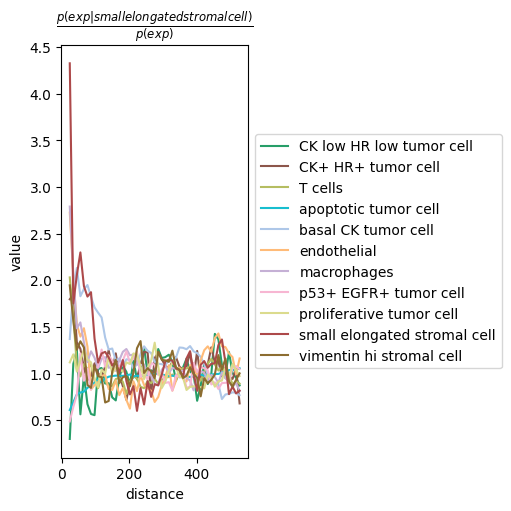

In [58]:
sq.pl.co_occurrence(adata, cluster_key="cell type", clusters="small elongated stromal cell")

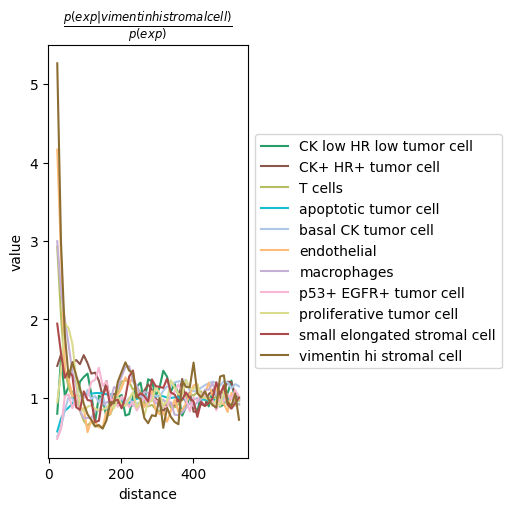

In [59]:
sq.pl.co_occurrence(adata, cluster_key="cell type", clusters="vimentin hi stromal cell")

pick one reference cell and then plot the cells that are in the interval of the dist matrix and plot these for the single reference cell. Should show that the interval is in fact considering only cells in the interval and not those from the reference outward

In [60]:
sq.gr.spatial_neighbors(adata, delaunay=True, coord_type="generic")

/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


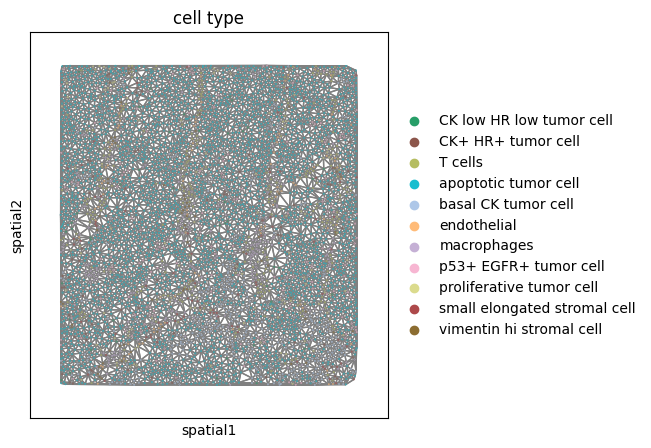

In [63]:
sq.pl.spatial_scatter(
    adata,
    shape=None,
    color="cell type",
    connectivity_key="spatial_connectivities",
    size=0.1,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 142.47/s]


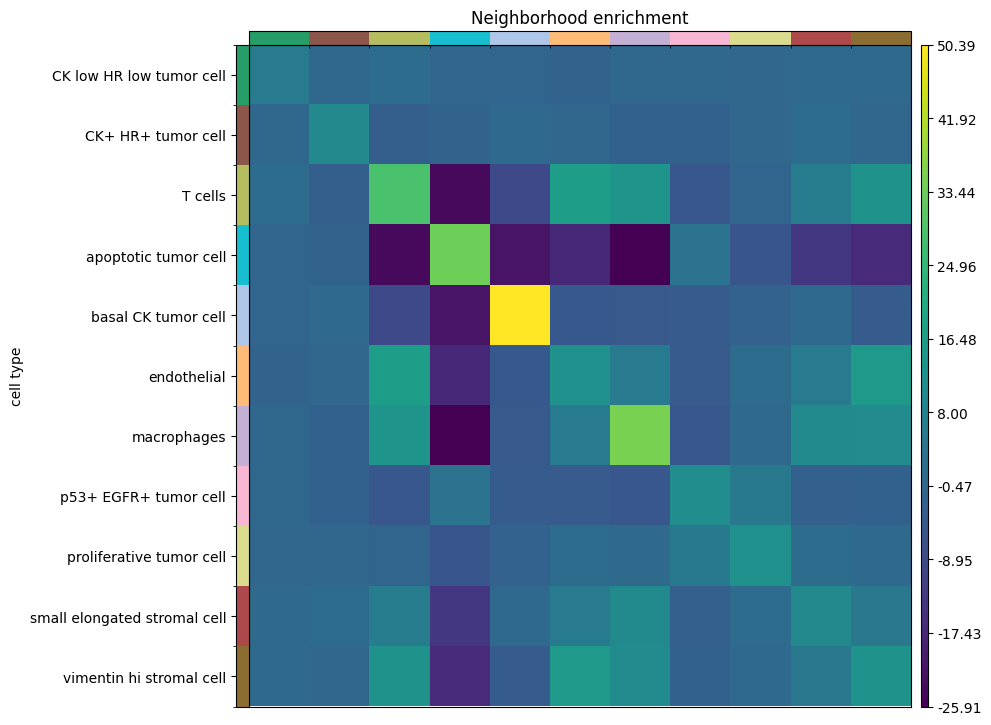

In [64]:
sq.gr.nhood_enrichment(adata, cluster_key="cell type")
sq.pl.nhood_enrichment(adata, cluster_key="cell type")

in short, it’s an enrichment score on spatial proximity of clusters: if spots belonging to two different clusters are often close to each other, then they will have a high score and can be defined as being enriched. On the other hand, if they are far apart, the score will be low and they can be defined as depleted. This score is based on a permutation-based test, and you can set the number of permutations with the n_perms argument (default is 1000).


So how does this actually work? 

I used to use a permutation test where cell labels would be shuffled a bunch for create a null distribution of cell types that were neighbors with another cell type. How similar is this method, and what are the permutations here? Is there a scale that is involved? Are the neighbors just the ones that are defined in the connectivity graph?

In [72]:
import numba.types as nt
import numpy as np
dt = nt.uint32  # data type aliases (both for numpy and numba should match)
ndt = np.uint32

In [69]:
adj = adata.obsp['spatial_connectivities']
adj

<4668x4668 sparse matrix of type '<class 'numpy.float64'>'
	with 27954 stored elements in Compressed Sparse Row format>

In [73]:
original_clust = adata.obs["cell type"]
clust_map = {v: i for i, v in enumerate(original_clust.cat.categories.values)}  # map categories
int_clust = np.array([clust_map[c] for c in original_clust], dtype=ndt)

In [74]:
original_clust

0        apoptotic tumor cell
1        apoptotic tumor cell
2       p53+ EGFR+ tumor cell
3        apoptotic tumor cell
4        apoptotic tumor cell
                ...          
4707     apoptotic tumor cell
4708     apoptotic tumor cell
4709     apoptotic tumor cell
4710    p53+ EGFR+ tumor cell
4711     apoptotic tumor cell
Name: cell type, Length: 4668, dtype: category
Categories (11, object): ['CK low HR low tumor cell', 'CK+ HR+ tumor cell', 'T cells', 'apoptotic tumor cell', ..., 'p53+ EGFR+ tumor cell', 'proliferative tumor cell', 'small elongated stromal cell', 'vimentin hi stromal cell']

In [75]:
clust_map

{'CK low HR low tumor cell': 0,
 'CK+ HR+ tumor cell': 1,
 'T cells': 2,
 'apoptotic tumor cell': 3,
 'basal CK tumor cell': 4,
 'endothelial': 5,
 'macrophages': 6,
 'p53+ EGFR+ tumor cell': 7,
 'proliferative tumor cell': 8,
 'small elongated stromal cell': 9,
 'vimentin hi stromal cell': 10}

In [76]:
int_clust

array([3, 3, 7, ..., 3, 7, 3], dtype=uint32)

In [77]:
indices, indptr = (adj.indices.astype(ndt), adj.indptr.astype(ndt))
n_cls = len(clust_map)

In [78]:
indices

array([  93,   56,   98, ..., 4592, 4617, 4566], dtype=uint32)

In [79]:
indptr

array([    0,     6,    11, ..., 27941, 27949, 27954], dtype=uint32)

tri = Delaunay(coords)
indptr, indices = tri.vertex_neighbor_vertices

In [80]:
n_cls

11

zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)

I think it shuffles the labels, and uses a function which counts the number of connections between clusters.

so Z score is the real counts of connections for a given reference clusters and a given query cluster, compared to the shuffled null

This score is based on the actual connections.
Although they have a radius distance metric as well to compute connections in addition to the dulaney or specifing a fixed number of the closest spots for each spot as neighbors


what if I do the radius (to grab cells within lets say 50) and then the permutations. Compare to my own?
I guess the difference here is the shuffling is global like what I do. I also use Z scores.

My assumptions is you'd get a lot of significant hits here like I did

Otherwise with Delauney, its basically the immediate neighbors, so use a distance of like d=10? d=20? and see what my global shuffling lookes like?

so is do radius of 50, should be very similar to my result of d=50 and global shuffling.

In [84]:
sq.gr.spatial_neighbors(adata, radius=50, coord_type="generic", key_added='spatial_distances')

In [85]:
adata.uns_keys

<bound method AnnData.uns_keys of AnnData object with n_obs × n_vars = 4668 × 34
    obs: 'cell type'
    uns: 'cell type_colors', 'cell type_co_occurrence', 'spatial_neighbors', 'cell type_nhood_enrichment', 'cell type_interactions', 'spatial_distances_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances', 'spatial_distances_connectivities', 'spatial_distances_distances'>

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 105.44/s]


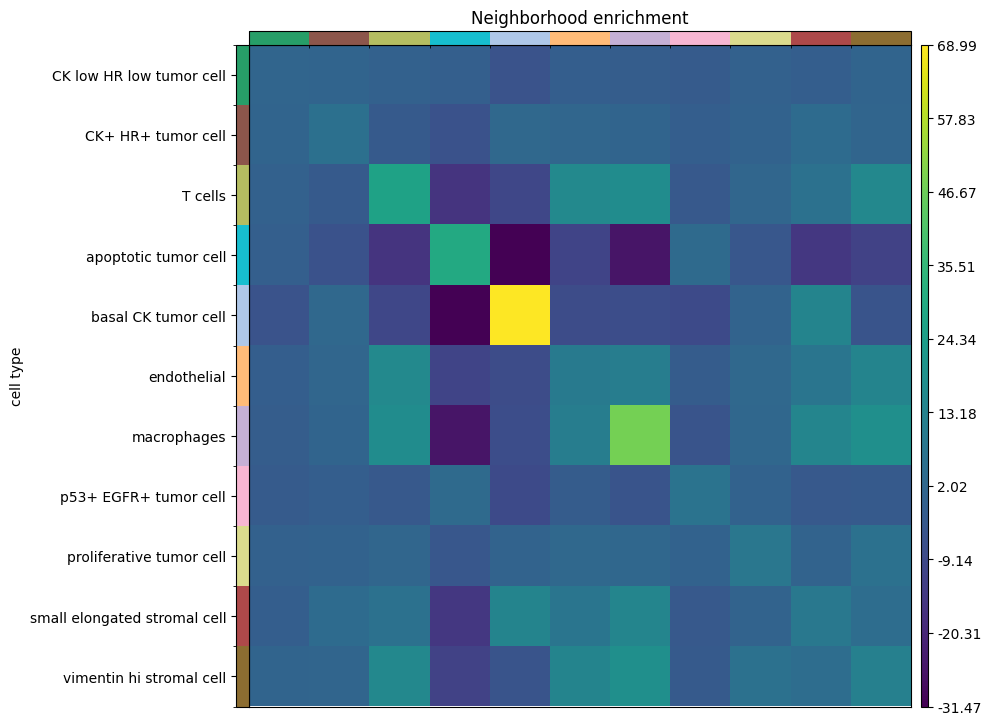

In [86]:
sq.gr.nhood_enrichment(adata, cluster_key="cell type", connectivity_key='spatial_distances')
sq.pl.nhood_enrichment(adata, cluster_key="cell type")

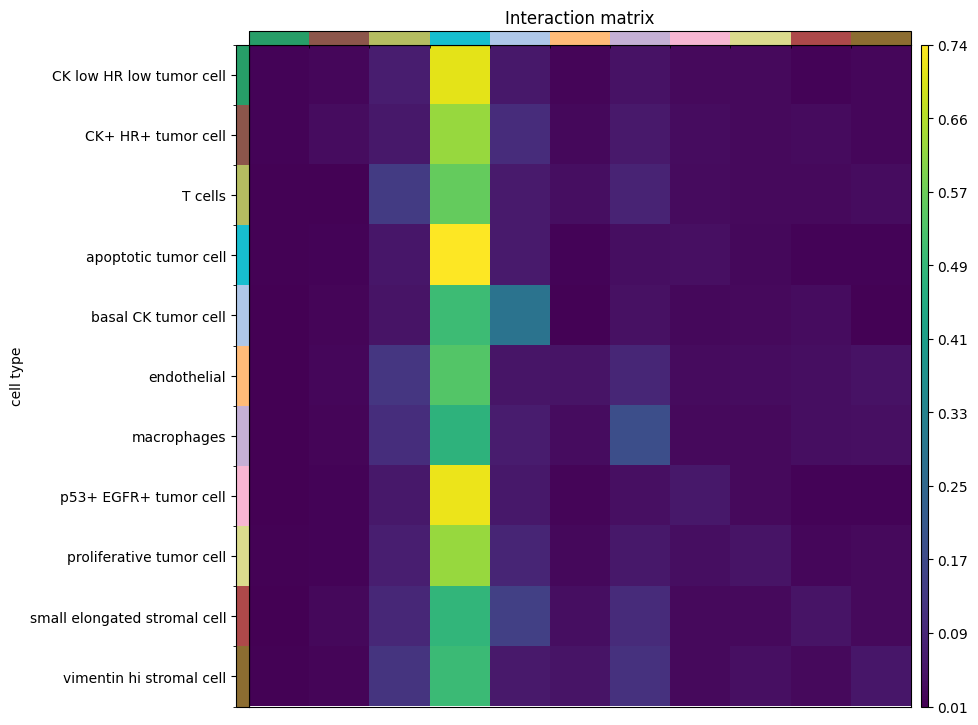

In [131]:
sq.gr.interaction_matrix(adata, cluster_key="cell type", normalized=True)
sq.pl.interaction_matrix(adata, cluster_key="cell type")

For instance, the interaction matrix, which counts the number of edges that each cluster share with all the others. This is exactly what it is



if normalized, then everyone hits apoptotic tumor cells cause they are everywhere

In [87]:
cats = adata.obs["cell type"]
mask = ~pd.isnull(cats).values
cats = cats.loc[mask]

In [88]:
cats

0        apoptotic tumor cell
1        apoptotic tumor cell
2       p53+ EGFR+ tumor cell
3        apoptotic tumor cell
4        apoptotic tumor cell
                ...          
4707     apoptotic tumor cell
4708     apoptotic tumor cell
4709     apoptotic tumor cell
4710    p53+ EGFR+ tumor cell
4711     apoptotic tumor cell
Name: cell type, Length: 4668, dtype: category
Categories (11, object): ['CK low HR low tumor cell', 'CK+ HR+ tumor cell', 'T cells', 'apoptotic tumor cell', ..., 'p53+ EGFR+ tumor cell', 'proliferative tumor cell', 'small elongated stromal cell', 'vimentin hi stromal cell']

In [89]:
mask

array([ True,  True,  True, ...,  True,  True,  True])

In [90]:
cats

0        apoptotic tumor cell
1        apoptotic tumor cell
2       p53+ EGFR+ tumor cell
3        apoptotic tumor cell
4        apoptotic tumor cell
                ...          
4707     apoptotic tumor cell
4708     apoptotic tumor cell
4709     apoptotic tumor cell
4710    p53+ EGFR+ tumor cell
4711     apoptotic tumor cell
Name: cell type, Length: 4668, dtype: category
Categories (11, object): ['CK low HR low tumor cell', 'CK+ HR+ tumor cell', 'T cells', 'apoptotic tumor cell', ..., 'p53+ EGFR+ tumor cell', 'proliferative tumor cell', 'small elongated stromal cell', 'vimentin hi stromal cell']

In [91]:
g = adata.obsp['spatial_connectivities']
g = g[mask, :][:, mask]
n_cats = len(cats.cat.categories)

In [96]:
weights = False
g_data = g.data if weights else np.broadcast_to(1, shape=len(g.data))
dtype = int if pd.api.types.is_bool_dtype(g.dtype) or pd.api.types.is_integer_dtype(g.dtype) else float
output = np.zeros((n_cats, n_cats), dtype=dtype)

In [97]:
g_data

array([1, 1, 1, ..., 1, 1, 1])

In [98]:
g_data.shape

(273646,)

In [99]:
output

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [100]:
output.shape

(11, 11)

In [101]:
g.indices

array([   1,    2,   41, ..., 4664, 4665, 4666], dtype=int32)

In [102]:
g.indptr

array([     0,     31,     75, ..., 273562, 273603, 273646], dtype=int32)

In [103]:
g.indptr.shape

(4669,)

In [111]:
indices_list = np.split(g.indices, g.indptr[1:-1])
indices_list

[array([  1,   2,  41,  43,  56,  58,  72,  93,  98, 123, 131, 135, 150,
        151, 162, 172, 183, 184, 195, 200, 211, 235, 268, 282, 283, 291,
        302, 329, 347, 352, 364], dtype=int32),
 array([  0,   2,  35,  41,  43,  56,  58,  72,  83,  93,  98, 115, 123,
        131, 135, 145, 150, 151, 162, 172, 173, 183, 184, 195, 200, 206,
        211, 221, 235, 250, 268, 272, 282, 283, 291, 302, 317, 329, 348,
        352, 353, 354, 364, 384], dtype=int32),
 array([  0,   1,  35,  41,  43,  56,  58,  59,  72,  83,  93,  98, 110,
        115, 123, 135, 145, 150, 151, 162, 172, 173, 184, 195, 200, 206,
        211, 221, 235, 250, 268, 272, 283, 285, 291, 317, 329, 348, 353,
        354, 384], dtype=int32),
 array([ 33,  34,  36,  44,  48,  49,  59,  64,  65,  73,  83,  94,  99,
        110, 113, 124, 125, 142, 143, 144, 163, 166, 173, 176, 185, 186,
        190, 196, 207, 208, 209, 222, 247, 251, 252, 259, 264, 309, 323,
        339, 349, 372], dtype=int32),
 array([ 25,  29,  34,  37,  3

In [106]:
data_list = np.split(g_data, g.indptr[1:-1])
data_list

[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1,

In [107]:
range(len(data_list))

range(0, 4668)

In [117]:
cats

0        apoptotic tumor cell
1        apoptotic tumor cell
2       p53+ EGFR+ tumor cell
3        apoptotic tumor cell
4        apoptotic tumor cell
                ...          
4707     apoptotic tumor cell
4708     apoptotic tumor cell
4709     apoptotic tumor cell
4710    p53+ EGFR+ tumor cell
4711     apoptotic tumor cell
Name: cell type, Length: 4668, dtype: category
Categories (11, object): ['CK low HR low tumor cell', 'CK+ HR+ tumor cell', 'T cells', 'apoptotic tumor cell', ..., 'p53+ EGFR+ tumor cell', 'proliferative tumor cell', 'small elongated stromal cell', 'vimentin hi stromal cell']

In [118]:
for i in range(len(data_list)):
    cur_row = clust_map[cats[i]]
    cur_indices = indices_list[i]
    cur_data = data_list[i]
    for j, val in zip(cur_indices, cur_data):
        cur_col = clust_map[cats[j]]
        print(cur_col)
        output[cur_row, cur_col] += val

3
7
3
3
3
3
3
7
3
8
3
3
3
8
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
0
3
3
7
3
3
3
3
3
3
3
7
3
3
8
3
3
8
3
8
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
8
3
8
3
8
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
3
3
3
3
3
3
3
8
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
7
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
7
3
3
3
7
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
3
3
4
3
3
3
3
7
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
0
0
3
3
3
3
3
3
3
6
3
3
6
3
0
3
3
3
3
3
3
3
3
3
3
3
3
6
3
3
3
3
0
3
3
3
3
3
3
3
3
3
3
3
3
0
0
3
3
3
3
6
3
6
3
0
3
3
3
3
3
3
3
3
3
3
2
3
6
3
3
3
0
3
3
3
3
3
3
3
3
3
3
3
0
0
3
3
3
3
6
3
6
0
3
6
3
3
3
3
6
3
6
3
2
6
3
6
3
3
0
2
3
6
8
3
0
3
3
9
9
10
2
3
5
6
2
6
9
2
3
3
6
6
2
6
6
4
3
3
2
3
6
8
3
3
3
3
1
9
9
3
10
3
2
8
2
6
3
6
4
6
2
6
4
3
3
2
3
6
8
3
3
3
3
1
3
9
3
3
3
8
1
6
3
4
1
6
4
6
6
4
4
3
3
2
3
3
3
1
8
3
3
3
3
3
1
3
3
3
3
3
3
1
3
3
0
1
1
4
4
3
4
1
8
3
3
3
3
3
3
3
3
1


3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
4
3
3
4
3
3
2
3
1
4
3
3
2
3
3
1
3
3
3
3
3
9
6
3
6
3
2
2
3
2
3
9
2
5
2
5
2
2
5
5
2
2
3
10
10
3
3
6
2
3
3
3
3
3
3
7
3
1
3
3
3
3
6
3
6
6
3
6
6
3
6
3
3
6
6
3
2
3
6
3
6
3
3
6
3
3
6
6
3
6
6
3
6
7
3
2
3
3
3
6
3
3
3
7
3
8
3
7
3
7
3
7
3
3
3
3
3
3
3
3
3
4
3
9
4
3
3
4
4
3
1
0
2
3
1
3
3
3
3
3
6
3
10
5
8
10
5
2
10
10
5
10
6
9
9
6
6
6
6
6
10
3
6
6
6
3
2
8
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
7
3
3
3
8
3
3
3
4
3
3
3
3
3
3
3
3
3
3
8
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
0
4
1
3
2
3
2
1
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
3
3
7
3
3
3
3
8
3
3
3
3
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
4
7
3
3
3
3
3
3
8
3
3
3
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
3
3
4
3
3
3
4
3
3
3
3
1
4
3
3
2
3
3
3
3
3
1
3
3
3
3
3
3
9
6
3
6
3
2
3
2
3
9
8
2
5
5
2
5
5
2
3
5
10
10
3
6
2
3
3
3
3
3
3
7
3
3
6
2
6
3
2
2
2
3
1
2
2
3
2
3
2
2
3
2
5
5
9
6
6
5
10
2
2
9
5
2
5
2
2
2
3
2
3
3
3
10
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
6
6
6
3
6
6
6
3
3
6
6
6
3
2
3
3
6
3
6
3


3
8
3
7
3
3
3
3
7
3
8
3
8
4
3
3
3
3
6
5
7
3
3
5
3
7
10
3
3
9
3
9
3
3
3
2
10
3
6
5
5
5
10
2
5
2
6
3
3
3
2
2
6
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
8
3
3
3
3
3
2
3
7
3
6
2
3
3
3
3
3
3
7
3
3
3
0
3
3
7
3
3
7
3
3
9
3
3
3
3
3
3
3
7
3
3
3
3
3
3
3
3
3
3
3
3
3
0
3
3
3
3
6
3
3
3
3
3
10
6
6
6
6
6
2
8
0
3
6
8
6
3
4
10
10
3
10
10
5
2
3
3
2
3
4
8
1
3
5
3
8
10
3
3
7
3
3
3
8
3
8
4
4
8
8
3
6
3
5
3
4
5
3
6
6
3
6
2
8
3
3
6
4
8
6
4
4
10
3
4
10
5
3
2
3
3
3
2
3
4
1
3
4
5
4
10
3
3
3
4
3
4
8
8
4
4
8
3
4
4
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
5
10
2
5
2
3
5
10
2
3
2
6
3
3
2
3
8
3
3
3
3
3
3
3
3
3
3
1
3
3
7
3
8
0
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
0
3
3
3
3
3
3
3
9
3
9
3
3
3
3
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
7
3
3
3
3
3
3
3
3
3
4
3
3
3
3
4
3
4
4
4
3
4
3
3
3
3
3
4
1
4
8
3
4
4
8
4
4
8
3
4
4
3
3
3
3
3
3
3
2
10
10
6
2
5
5
5
2
5
6
3
3
3
3
6
3
3
3
3
3
3
3
3
7
3
3
3
3
3
3
3
3
3
3
3
3
3
3


3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
10
3
3
3
3
3
3
3
3
3
3
3
3
6
3
3
3
3
3
3
0
3
3
3
3
3
3
3
3
6
3
2
6
2
2
5
9
3
3
7
3
10
7
3
3
3
3
1
2
3
3
5
3
3
3
3
3
3
3
3
3
3
6
3
2
3
3
8
3
3
8
6
3
5
3
6
3
2
2
6
2
6
2
10
3
7
3
3
3
7
3
7
10
7
7
3
3
3
3
2
3
3
3
5
3
3
3
2
3
3
6
3
3
3
6
6
2
3
8
3
3
8
6
6
3
5
6
6
9
3
2
2
6
2
6
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
6
3
4
3
3
3
3
3
3
3
4
3
3
3
3
4
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
6
3
3
3
3
7
3
3
3
3
3
1
3
7
3
3
3
3
3
3
3
6
3
2
2
3
3
6
3
3
3
3
3
3
9
3
3
3
3
7
8
3
3
3
3
3
3
3
0
3
3
3
3
3
3
3
2
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
7
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
8
3
3
2
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
3
2


3
3
5
2
2
2
2
2
10
3
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
3
3
3
7
3
3
3
2
5
2
10
10
10
2
6
2
2
2
2
2
3
6
2
2
3
2
3
6
2
3
3
8
3
3
3
3
3
3
7
3
3
8
3
3
3
3
3
3
3
3
4
4
3
3
3
3
1
4
3
4
3
3
3
3
4
3
3
3
3
3
3
3
3
6
2
3
10
3
2
3
2
6
3
2
2
6
6
10
6
2
9
6
5
3
3
6
5
4
3
3
4
3
3
3
3
3
3
3
4
4
3
3
3
4
4
3
3
7
7
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
9
3
7
3
3
7
3
3
3
7
3
7
3
3
3
3
3
3
2
2
2
2
2
5
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
8
8
3
3
8
3
3
3
3
3
6
3
3
3
3
3
2
3
2
6
3
2
2
9
6
10
6
2
9
6
5
3
3
6
5
3
3
6
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
4
3
3
3
7
3
3
7
6
3
3
3
6
3
3
6
10
6
10
5
10
5
10
10
2
6
6
2
6
2
6
8
2
3
10
3
3
7
3
7
7
3
3
3
3
3
3
3
3
4
3
3
3
1
3
3
3
3
3
3
3
3
6
3
3
3
3
3
3
3
3
6
3
3
3
3
3
6
3
3
3
3
3
9
3
2
6
3
2
9
6
10
6
6
5
3
3
3
6
5
3
3
6
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
3
7
7
3
3
3
7
6
3
3
6
3
3
3
2
6
9
2
4
8
2
9
6
6
4
3
2
8
8
9
4
4
4
3
8
9
3
3
4
4
3
3
3
2
3
4
2
3
4
3
3
4
3
4
9
3
2
4
7
9
3
4
9
3
3
6
9
4
3
3
3
4
3
3
3
3
3
3
3
3
3
3
3
3


4
3
6
3
4
3
3
3
3
3
3
6
3
4
3
3
3
10
3
3
6
2
9
2
2
3
6
6
6
3
3
3
3
3
3
3
3
3
3
3
4
3
4
4
4
4
4
4
4
4
4
4
3
4
4
4
3
4
4
4
3
4
3
4
4
2
1
8
3
1
3
3
9
3
3
7
3
3
8
3
4
4
3
3
3
4
4
4
6
6
6
3
4
3
3
3
4
3
3
3
3
3
3
4
3
4
3
4
4
4
4
4
4
4
4
4
3
4
3
4
4
4
4
3
4
3
4
3
3
4
4
4
3
3
3
9
3
3
3
7
3
4
3
4
4
3
3
3
4
4
4
4
6
3
3
3
4
3
3
3
3
4
3
4
3
4
4
4
6
4
4
4
4
4
3
3
4
4
4
4
4
4
3
4
4
3
3
4
4
4
4
3
4
3
3
9
3
3
3
3
3
4
3
4
3
3
3
4
4
4
4
4
3
4
0
3
3
3
3
3
3
3
3
3
3
3
3
3
6
3
3
3
3
3
3
3
3
3
3
7
3
4
4
3
3
3
8
3
7
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
0
8
3
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
6
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
6
3
3
3
3
3
3
3
3
3
0
3
3
3
3
3
3
3
0
6
3
3
0
3
3
3
4
3
3
3
4
7
3
3
3
4
3
4
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
2
3
3
2
3
3
7
3
6
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
4
3
3
3
3
4
4
3
3
4
3
6
3
1
4
3
3
3
3
3
6
3
4
3
3
10
3
2
6
2
9
2
2
6
6
2
3
3
3
3
3
3
3
3
3
7
7
3
3
3
4
3
3
0
7
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
0
3
3
3
3
3
3
3
3
1
3
3
3
3
3
3
3
3
3
6
3
3
3
3
3
3
3
7
7
3
3
4
3
3
3
3
3


1
3
3
3
3
3
3
3
3
3
3
3
3
1
4
4
4
3
3
3
3
4
3
3
4
3
3
8
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
6
3
10
3
2
9
5
6
6
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
8
3
3
3
3
4
3
3
3
3
9
3
6
3
6
6
2
2
2
10
2
9
6
2
2
5
2
3
5
6
6
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
8
3
4
3
3
4
3
4
4
3
3
2
4
3
9
3
3
3
7
3
3
3
3
3
3
3
3
3
3
3
4
3
3
4
3
3
3
4
3
3
3
8
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
6
6
2
2
2
2
10
2
6
6
2
5
2
5
6
5
10
3
6
3
3
10
2
6
2
9
2
2
6
6
6
6
6
6
2
6
6
6
6
2
6
6
6
6
6
6
6
6
6
8
6
10
5
6
5
9
10
6
2
6
6
6
6
6
6
2
2
2
2
10
6
6
6
6
3
4
7
4
4
3
3
3
4
3
4
4
3
4
4
3
3
4
4
4
3
0
4
3
3
4
3
3
7
4
3
3
8
4
7
3
7
3
3
4
3
4
3
3
3
3
4
3
4
3
3
4
3
4
3
3
3
3
3
4
3
3
3
3
3
3
3
3
6
3
3
3
3
3
3
3
3
6
4
3
3
6
3
3
3
3
6
3
3
3
3
3
3
3
3
3
3
7
3
3
3
7
3
3
3
3
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
2
3
3
2
3
3
3
6
3
6
6
3
2
3
3
6
6
6
6
3
6
6
3
8
6
10
6
6
5
5
9
4
3
3
9
6
3
6
6
6
5
6
6
6
2
6
9
2
6
9
6
4
6
3
1
3
3
3
3
0
3

3
3
3
9
3
3
3
3
3
3
3
3
3
3
4
3
3
4
3
3
4
9
3
3
4
0
3
3
3
3
2
8
2
8
8
2
2
2
3
3
10
3
3
3
3
3
3
3
3
3
8
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
9
2
3
2
5
3
9
2
4
5
2
3
3
3
3
3
3
3
3
3
7
3
2
3
3
8
3
3
3
3
3
3
3
7
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
2
3
4
3
9
3
3
4
3
3
3
0
3
3
3
3
3
2
3
5
2
2
9
2
2
10
3
3
3
3
3
3
3
3
3
7
3
3
3
3
8
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
9
3
3
3
3
3
3
3
3
3
3
3
3
0
4
3
3
3
3
3
3
3
3
3
4
3
3
8
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
3
3
3
0
0
3
3
3
3
3
4
3
7
3
3
3
4
3
8
3
3
3
3
3
3
3
7
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
8
3
3
3
4
7
3
3
3
3
3
8
7
3
3
3
3
3
3
3
3
3
3
3
8
8
4
3
4
4
3
3
3
4
8
2
3
6
3
4
3
10
4
4
4
4
1
3
2
3
3
3
4
6
9
4
3
4
4
3
6
3
3
3
3
0
10
4
4
3
4
3
4
2
3
3
3
3
3
3
3
3
3
4
3
4
8
4
4
3
4
3
4
3
3
8
2
3
6
4
7
3
8
10
2
4
4
2
3
7
3
3
4
6
9
4
4
7
3
3
6
3
3
10
4
3
4
4
3
4
3
3
3
3
3
3
3
3
3
3
4
3
3
3
3
3
3
3
3
3
3
9
2
3
2
5
3
9
2
2
4
5
2
3
3
3
3


3
4
3
3
3
2
5
3
2
3
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
0
3
3
9
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
2
6
3
2
6
3
5
6
6
4
6
2
6
9
6
6
6
6
10
10
2
3
3
4
3
3
8
3
3
0
3
10
3
3
6
3
4
3
3
6
4
4
4
8
3
3
4
4
4
4
4
4
4
3
4
3
4
4
9
3
3
1
3
4
4
4
4
4
4
3
3
4
4
4
4
4
4
4
4
4
4
4
4
3
3
6
3
10
4
3
4
4
3
3
4
3
3
3
4
4
4
4
3
4
4
4
4
4
3
4
4
4
4
4
3
4
4
9
4
3
9
4
4
3
3
2
5
5
9
4
4
1
2
3
5
2
4
1
9
9
1
6
4
3
3
3
3
3
2
3
3
3
3
3
2
2
3
3
3
2
5
3
3
2
3
3
3
3
3
3
8
3
3
7
8
0
7
5
3
8
3
8
8
8
2
8
1
2
6
10
5
5
2
2
3
4
4
2
4
6
3
10
10
3
4
6
4
4
3
6
4
4
3
4
4
3
4
6
4
4
4
8
4
4
3
3
4
4
3
6
4
4
2
3
4
8
4
4
4
4
3
2
4
4
3
2
3
2
3
10
3
3
3
3
4
3
3
8
3
0
3
3
3
6
3
3
4
3
6
4
4
4
8
3
3
4
4
4
4
4
4
4
4
3
3
4
4
4
3
3
1
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
10
4
4
4
4
9
3
3
3
3
3
9
3
3
3
3
3
3
3
3
3
3
3
3
3
6
2
2
3
3
3
5
3
3
3
3
2
2
3
3
3
3
3
2
3
3
7
3
3
3
3
2
3
3
3
3
3
2
5
2
2
2
2
2
3
4
3
2
2
5
2
6
2
4
3
6
10
10
3
4
6
4
4
3
3
4
3
4
3
4
4
6
3
4
4
8
4
3
3
3
3
2
2
9
4
6
2
4
8
2
3
4
8
4
7
4
3
2
4
3
8
3
3
3
2
3
3
3
3
3
3
3
3
3

3
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
3
3
3
3
2
2
9
9
2
3
2
10
5
3
3
2
3
3
3
3
2
3
2
3
1
3
3
3
3
2
3
3
3
3
3
3
9
3
3
3
4
9
5
8
2
2
2
3
3
3
1
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
7
3
7
3
3
3
3
3
4
3
3
3
3
4
3
3
3
3
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
3
5
5
2
2
5
2
2
9
3
3
3
3
3
3
3
3
3
3
3
3
3
1
3
3
1
3
3
3
3
3
3
3
3
3
3
9
3
3
3
6
2
10
10
2
3
3
3
3
1
3
3
3
3
3
3
3
3
3
3
3
7
3
3
3
3
3
3
3
3
1
3
3
3
3
7
7
3
3
3
3
3
7
3
3
3
3
3
3
3
3
3
7
3
3
3
3
7
3
3
3
3
3
3
3
3
7
3
7
3
7
10
3
3
3
3
7
7
3
3
3
3
3
3
3
3
7
4
9
6
4
3
3
4
9
4
6
4
3
4
6
4
6
9
3
3
3
3
3
3
5
4
3
3
4
9
1
3
9
3
3
4
3
3
3
2
3
3
3
7
7
7
3
3
3
3
3
3
3
3
3
3
3
3
3
1
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
7
8
3
3
7
3
3
3
3
7
3
3
3
3
3
3
3
3
3
3
3
3
3
3
6
3
3
3
3
3
1
3
3
3
3
3
3
3
3
3
3
3
3
8
3
3
3
3
3
1
3
3
3
3
3
3
7
3
3
3
3
3
7
2
3
3
3
7
7
7
3
3
3
3
3
3
3
3
3
3
3
3
1
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
7
3
2
2
2
3
3
3
3
2
3
3
3
3
2
3
3
2
3
3
3
3
3


In [119]:
output

array([[3.80000e+01, 4.70000e+01, 1.72000e+02, 1.85200e+03, 1.39000e+02,
        4.10000e+01, 1.14000e+02, 6.70000e+01, 6.30000e+01, 3.90000e+01,
        5.30000e+01],
       [4.70000e+01, 1.18000e+02, 2.04000e+02, 2.36900e+03, 3.73000e+02,
        8.60000e+01, 2.11000e+02, 1.20000e+02, 9.60000e+01, 1.03000e+02,
        7.80000e+01],
       [1.72000e+02, 2.04000e+02, 2.27800e+03, 9.62800e+03, 1.00000e+03,
        5.82000e+02, 1.33800e+03, 4.99000e+02, 4.35000e+02, 4.11000e+02,
        5.28000e+02],
       [1.85200e+03, 2.36900e+03, 9.62800e+03, 1.36708e+05, 1.09580e+04,
        2.60100e+03, 6.37700e+03, 6.53700e+03, 4.02700e+03, 2.27600e+03,
        2.27700e+03],
       [1.39000e+02, 3.73000e+02, 1.00000e+03, 1.09580e+04, 6.18800e+03,
        2.36000e+02, 8.22000e+02, 4.93000e+02, 5.37000e+02, 6.71000e+02,
        2.58000e+02],
       [4.10000e+01, 8.60000e+01, 5.82000e+02, 2.60100e+03, 2.36000e+02,
        2.16000e+02, 4.05000e+02, 1.38000e+02, 1.41000e+02, 1.56000e+02,
        2.0100

In [130]:

output.sum(axis=1).reshape((-1, 1))

array([[  2625.],
       [  3805.],
       [ 17075.],
       [185610.],
       [ 21675.],
       [  4803.],
       [ 13292.],
       [  9130.],
       [  6444.],
       [  4673.],
       [  4514.]])

if normalize, then divide each row by total
row = ref, col = query, I think

So would get proportion of interations to queries for each reference

For each cell, count number of interactions with each cell type

In [109]:
output

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [113]:
output = np.zeros((n_cats, n_cats), dtype=dtype)

In [114]:
output

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

We can further visualize tissue organization in spatial coordinates with
`squidpy.pl.spatial_scatter`.


/opt/miniconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


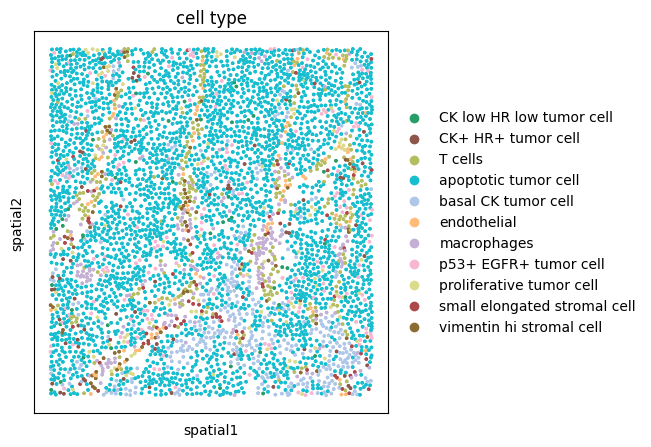

In [3]:
sq.pl.spatial_scatter(adata, color="cell type", size=10, shape=None)

In [45]:
df = pd.DataFrame(adata.obsm["spatial"], columns = ["x", "y"])

In [46]:
list(adata.obs["cell type"])

['apoptotic tumor cell',
 'apoptotic tumor cell',
 'p53+ EGFR+ tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'T cells',
 'macrophages',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'basal CK tumor cell',
 'CK low HR low tumor cell',
 'endothelial',
 'apoptotic tumor cell',
 'p53+ EGFR+ tumor cell',
 'p53+ EGFR+ tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'basal CK tumor cell',
 'basal CK tumor cell',
 'CK low HR low tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'vimentin hi stromal cell',
 'p53+ EGFR+ tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor cell',
 'apoptotic tumor 

In [47]:
df["cluster"] = list(adata.obs["cell type"])

In [48]:
df

x           y                cluster
0       1.709091   15.327273   apoptotic tumor cell
1       3.849462   42.075269   apoptotic tumor cell
2       0.866667   50.333333  p53+ EGFR+ tumor cell
3       1.388889  133.777778   apoptotic tumor cell
4       2.107143  199.660714   apoptotic tumor cell
...          ...         ...                    ...
4663  730.676471  624.588235   apoptotic tumor cell
4664  730.578947  631.894737   apoptotic tumor cell
4665  730.142857  636.964286   apoptotic tumor cell
4666  730.375000  658.041667  p53+ EGFR+ tumor cell
4667  729.876289  679.639175   apoptotic tumor cell

[4668 rows x 3 columns]

In [26]:
import pandas as pd

In [49]:
df[["x", "y", "cluster"]].to_csv("/Users/brendan/Desktop/PostDoc/work/HuBMAP/repos/multiscale_celltype_colocalization_analysis/data/squidpy/compute_co_occurance_data.csv")